# Pip installs for new enviroments

In [0]:
# !pip install keras
# !pip install keras.datasets
# !pip install mnist
# !pip install albumentations
# !pip install scipy

# Imports

In [2]:
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import cv2
import albumentations as amt
from scipy.ndimage import rotate, zoom

Using TensorFlow backend.


# ***1. Prepare training dataset*** 

In [0]:
plt.rcParams['image.cmap'] = 'gray'

## **a.** Loading mnist dataset


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


## Util functions

In [0]:
def norm(img):
  img = img.astype(np.float32)
  img -= img.min()
  img /= img.max()
  return img

In [0]:
def combine(im_and_lbl1, im_and_lbl2, im_and_lbl3):
  return np.concatenate((im_and_lbl1[0], im_and_lbl2[0], im_and_lbl3[0]), axis=1), (str(im_and_lbl1[1]) + str(im_and_lbl2[1]) + str(im_and_lbl3[1]))

In [0]:
def show_all(image_list, title_list, inarow=5):
  plt.figure(figsize=[20,10])
  assert len(image_list) == len(title_list), "Houston we've got a problem"
  N = len(image_list)
  lines = int(N / inarow)+1
  for index, (img, title) in enumerate(zip(image_list, title_list)):
    plt.subplot(lines, inarow, index+1)
    if len(img.shape) != 3:
      plt.imshow(img)
    else:
      plt.imshow(img)
    plt.title(title)

In [0]:
def get_all_digits():
  all_numbers = list()
  all_labels = list()
  for i in range(len(y_train)):
    if y_train[i] not in all_labels:
      all_labels.append(y_train[i])
      all_numbers.append(x_train[i])
    if len(all_labels) == 10:
      break
  return all_numbers, all_labels

In [0]:
def seperate_all_digits():
  sep_digits = {"0": [],
                "1": [],
                "2": [],
                "3": [],
                "4": [],
                "5": [],
                "6": [],
                "7": [],
                "8": [],
                "9": [] }
  
  for i in range(len(x_train)):
    sep_digits[str(y_train[i])].append(x_train[i])

  return sep_digits

In [0]:
def create_new_dataset(amount=6000):
  sep_digits = seperate_all_digits()
  new_x = []
  new_y = []
  for first_dig in sep_digits:
    for second_dig in sep_digits:
      for third_dig in sep_digits:
        for i in range(amount):
          st = (sep_digits[first_dig][np.random.randint(low=0, high=len(sep_digits[first_dig])-1)], first_dig)
          nd = (sep_digits[second_dig][np.random.randint(low=0, high=len(sep_digits[second_dig])-1)], second_dig)
          th = (sep_digits[third_dig][np.random.randint(low=0, high=len(sep_digits[third_dig])-1)], third_dig)
          new_num, new_lbl = combine(st, nd, th)
          new_x.append(new_num)
          new_y.append(new_lbl)
  
  return new_x, new_y

## **b.** Show digits 0-9

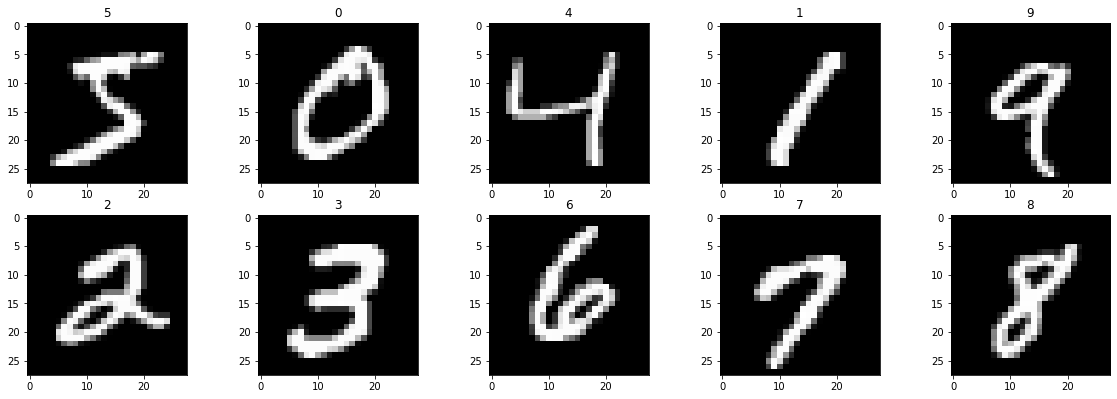

In [11]:
figures_images, figures_labels = get_all_digits()
show_all(figures_images, figures_labels)

## **c.** Create new dataset with digits in range of 0-999
@param: **amount** of how many different examples to generate for each number

In [0]:
# chose 10 instead of 6000 to run faster. (works with 6000 also)
x, y = create_new_dataset(amount=10)

## **d.** Show new dataset

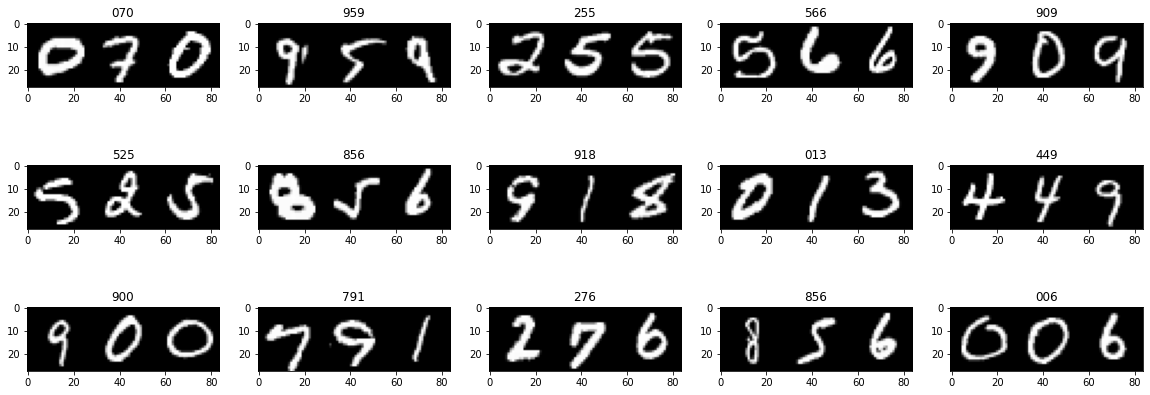

In [13]:
def choose_digits(x, y, num_of_digits=15):
  show_x = []
  show_y = []
  for i in range(num_of_digits):
    rand = np.random.randint(0, high=len(y)-1)
    show_x.append(x[rand])
    show_y.append(y[rand])
  return show_x, show_y

show_x, show_y = choose_digits(x, y)
show_all(show_x, show_y)

## **e.** Augmentation class

In [0]:
class Augmentation(object):
  def __init__(self):
    pass

  def flip_horizontal(self, img):
    horiz = amt.HorizontalFlip(p=1)
    return horiz(image=img)['image']

  def flip_vertical(self, img):
    vert = amt.VerticalFlip(p=1)
    return vert(image=img)['image']

  def rotate_by_degree(self, img, deg=-1):
    if deg == -1:
      deg = np.random.randint(0, high=360)
    rot = rotate(img, deg, reshape=False)
    return rot

  def gaussian_blur(self, img, k_size=3):
    return cv2.GaussianBlur(img, (k_size, k_size), 0)

  def median_blur(self, img, k_size=3):
    return cv2.medianBlur(img, k_size)
    
  def zoom(self, img, zoom_factor=None):
    if zoom_factor == None:
      zoom_factor = round(np.random.uniform(low=1.1, high=1.7), 2)

    height, width = img.shape[:2]
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result
    
  def crop(self, img, start_x : int, end_x : int, start_y : int, end_y: int):
    crop = amt.Crop(start_x, start_y, end_x, end_y)
    return crop(image=img)['image']

  def sharpen(self, img, sharpness=0.5, lightness=1):
    sharp = amt.IAASharpen(alpha=(sharpness,sharpness), lightness=(lightness,lightness), p=1)
    return sharp(image=img)['image']

  def distort(self, img):
    dist = amt.GridDistortion(p=1)
    return dist(image=img)['image']

  def elastic_distort(self, img, alpha=1, sigma=20, alpha_affine=5):
    e_dist = amt.ElasticTransform(alpha=alpha, sigma=sigma, alpha_affine=alpha_affine, p=1)
    return e_dist(image=img)['image']

  def motion_blur(self, img, k_max_size=5):
    if k_max_size < 3:
      print('k_max_size must have a value larger or equal to 3')
      return
    motion = amt.MotionBlur(blur_limit=k_max_size, p=1)
    return motion(image=img)['image']

  def gauss_noise(self, img, mean=0, sigma=20):
    gauss = np.random.normal(mean, sigma, img.shape)
    noisy = img + gauss
    return noisy

  def salt_pepper_noise(self, image, prob=0.1):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        rdn = np.random.random()
        if rdn < prob:
          output[i][j] = 0
        elif rdn > thres:
          output[i][j] = 255
        else:
          output[i][j] = image[i][j]
    return output

  def sobel_x(self, img, dx=1, ksize=3, scale=1):
    return cv2.Sobel(img, cv2.CV_8U, dx, 0, ksize=ksize, scale=scale)

  def sobel_y(self, img, dy=1, ksize=3, scale=1):
    return cv2.Sobel(img, cv2.CV_8U, 0, dy, ksize=ksize, scale=scale)

### Some augmented images:
The relevant augmentations are Gaussian-Blur and Median-Blur becuase they change the image just enough, and the figures meaning stays the same.
While the zoom, crop, and flips augmentations can cause manipulations which will change the meaning of the figures. Therefore are not usfull for this particular dataset.

Also, added augmentations like Distort, Motion-Blur, Guassian-Noise, Salt-&-Pepper-Noise and Sobels which are all usfull augmentation for this data because they are not changing the meaning of the figures so can be used to expand the dataset safely.

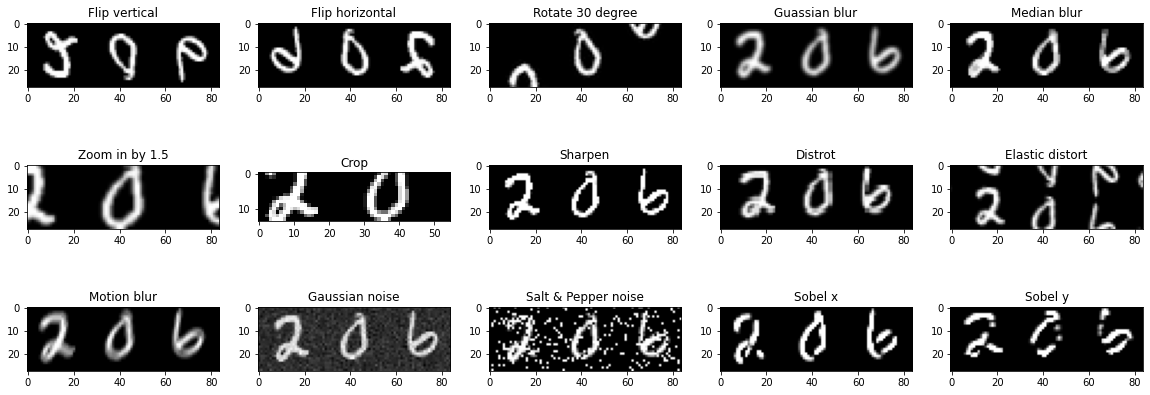

In [15]:
aug_x = []
aug_type = []
aug = Augmentation()

img, _ = choose_digits(x, y, num_of_digits=1)

aug_x.append(aug.flip_vertical(img[0]))
aug_type.append("Flip vertical")
aug_x.append(aug.flip_horizontal(img[0]))
aug_type.append("Flip horizontal")
aug_x.append(aug.rotate_by_degree(img[0], 30))
aug_type.append("Rotate 30 degree")
aug_x.append(aug.gaussian_blur(img[0], 3))
aug_type.append("Guassian blur")
aug_x.append(aug.median_blur(img[0], 3))
aug_type.append("Median blur")
aug_x.append(aug.zoom(img[0], 1.5))
aug_type.append("Zoom in by 1.5")
aug_x.append(aug.crop(img[0], 5, 60, 9, 23))
aug_type.append("Crop")
aug_x.append(aug.sharpen(img[0]))
aug_type.append("Sharpen")
aug_x.append(aug.distort(img[0]))
aug_type.append("Distrot")
aug_x.append(aug.elastic_distort(img[0]))
aug_type.append("Elastic distort")
aug_x.append(aug.motion_blur(img[0],5))
aug_type.append("Motion blur")
aug_x.append(aug.gauss_noise(img[0], 0, 20))
aug_type.append("Gaussian noise")
aug_x.append(aug.salt_pepper_noise(img[0]))
aug_type.append("Salt & Pepper noise")
aug_x.append(aug.sobel_x(img[0]))
aug_type.append("Sobel x")
aug_x.append(aug.sobel_y(img[0]))
aug_type.append("Sobel y")

show_all(aug_x, aug_type)

## **f.** Find contours

In [0]:
def find_and_draw_contours(img):
  canny_digit = cv2.Canny(img[0], 50, 150)
  contours, _ = cv2.findContours(canny_digit, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  img_digit_draw = cv2.cvtColor(img[0].copy(),cv2.COLOR_GRAY2RGB)
  img_digit_draw = cv2.drawContours(img_digit_draw, contours, -1, (0, 255, 0), 1)

  plt.figure(figsize=[10, 10])
  plt.subplot(121)
  plt.imshow(img[0])
  plt.title('real')
  plt.subplot(122)
  plt.imshow(img_digit_draw)
  plt.title('drawContours')
  plt.show()

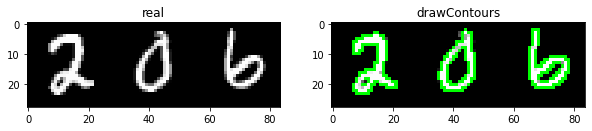

In [17]:
find_and_draw_contours(img)

## **g.** All data represented above.
### summary:
In this question we've been asked to expand the mnist dataset from digits in range of 0-9 to digits in range of 0-999.
Also, the dataset can be expanded even further more by applying some augmentations using the Augmenatation class built in this question.
Above there are all the images required to show: All digits from 0-9, some selected digits from 0-999, augmentation over a selected image, and finding edges of a number inside an image.
Some of the augmentations can be changed and be implemented in varius ways and settings.

With all the functions and data prepared from this question, one can build himself a dataset to train a Machine-Learning Algorithm to detect numbers from 0-999.

# ***2. Create training dataset***

## **a.** Create dataset constructed from the shapes: circle(ellipse), rectangle and trianle

In [0]:
set_shape = (50, 50, 3)

def random_color():
  return (np.random.randint(0, high=255), np.random.randint(0, high=255), np.random.randint(0, high=255))

### **i.)** Random triangle function

In [0]:
def random_triangle():
  img = np.zeros(set_shape)
  p1 = (np.random.randint(0, high=set_shape[0]-1), np.random.randint(0, high=set_shape[0]-1))
  p2 = (np.random.randint(0, high=set_shape[0]-1), np.random.randint(0, high=set_shape[0]-1))
  p3 = (np.random.randint(0, high=set_shape[0]-1), np.random.randint(0, high=set_shape[0]-1))
  color = random_color()
  
  cv2.line(img, p1, p2, color, 1) 
  cv2.line(img, p2, p3, color, 1) 
  cv2.line(img, p1, p3, color, 1) 

  return img.astype(np.uint8)

### **ii.)** Random rectangle function

In [0]:
def random_rectangle():
  img = np.zeros(set_shape)
  p1 = np.random.randint(0, high=set_shape[0]-1)
  p2 = np.random.randint(0, high=set_shape[0]-1)
  p3 = np.random.randint(0, high=set_shape[0]-1)
  p4 = np.random.randint(0, high=set_shape[0]-1)
  color = random_color()

  img = cv2.rectangle(img, (p1, p2), (p3, p4), color, 1)
  return img.astype(np.uint8)

### **ii.)** Random ellipse function

In [0]:
def random_ellipse(radius_x=10, radius_y=5):
  img = np.zeros(set_shape)
  radius_x = np.random.randint(1, high=(set_shape[0]/2)-1)
  radius_y = np.random.randint(1, high=(set_shape[1]/2)-1)
  center = (np.random.randint(0, high=set_shape[0]-1), np.random.randint(0, high=set_shape[0]-1))
  angle = np.random.randint(0, high=360)
  color = random_color()

  if center[0] <= 0+radius_x:
    center = (center[0] + radius_x, center[1])
  elif center[0] >= set_shape[0]-radius_x:
    center = (center[0] - radius_x, center[1])

  if center[1] <= 0+radius_y:
    center = (center[0], center[1] + radius_y)
  elif center[1] >= set_shape[1]-radius_y:
    center = (center[0], center[1] - radius_y)

  img = cv2.ellipse(img, center, (radius_x, radius_y), angle, 0, 360, color, 1)
  return img.astype(np.uint8)

## **b.** Show shapes created

In [0]:
def generate_shapes(amount=300):
  shapes = {"triangle": [],
            "rectangle": [],
            "ellipse": []}
            
  for i in range(amount):
    shapes["triangle"].append(random_triangle())
    shapes["rectangle"].append(random_rectangle())
    shapes["ellipse"].append(random_ellipse())
  
  return shapes

In [0]:
def prepare_show_set(shapes : dict, amount_each_shape=10):
  show_shapes = []
  show_lbls = []
  for shape in shapes:
    for i in range(amount_each_shape):
      show_shapes.append(shapes[shape][i])
      show_lbls.append(shape)

  return show_shapes, show_lbls

In [0]:
shapes = generate_shapes()

### Before augmentation:

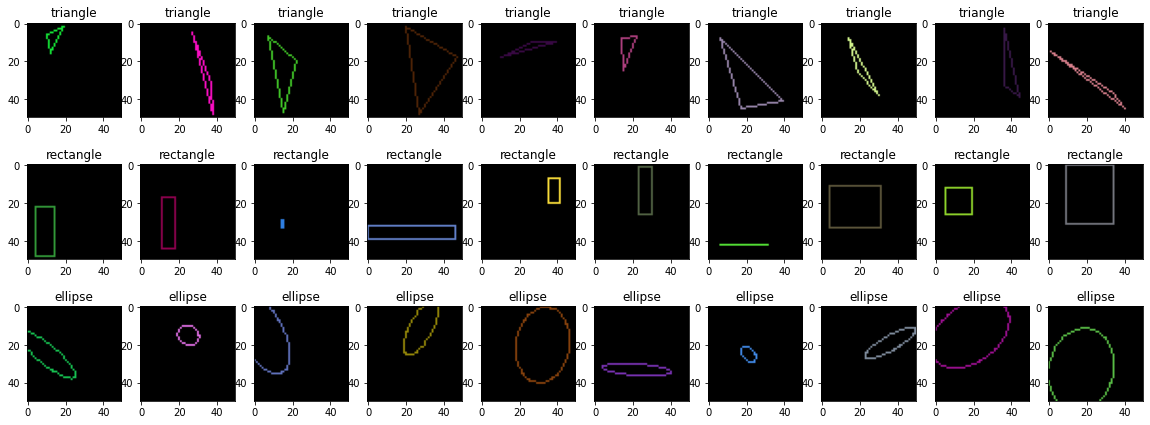

In [25]:
show_shapes, show_lbls = prepare_show_set(shapes)
show_all(show_shapes, show_lbls, 10)

### After augmentation:

In [0]:
def apply_augmentations(shapes : list):
  aug = Augmentation()
  augs = [aug.flip_horizontal, aug.flip_vertical, aug.gaussian_blur, aug.median_blur, aug.motion_blur, aug.salt_pepper_noise, aug.rotate_by_degree, aug.sharpen]

  for i in range(len(shapes)):
    rand_aug = np.random.randint(0, high=len(augs)-1)
    shapes[i] = augs[rand_aug](shapes[i]).astype(np.uint8)
  
  return shapes

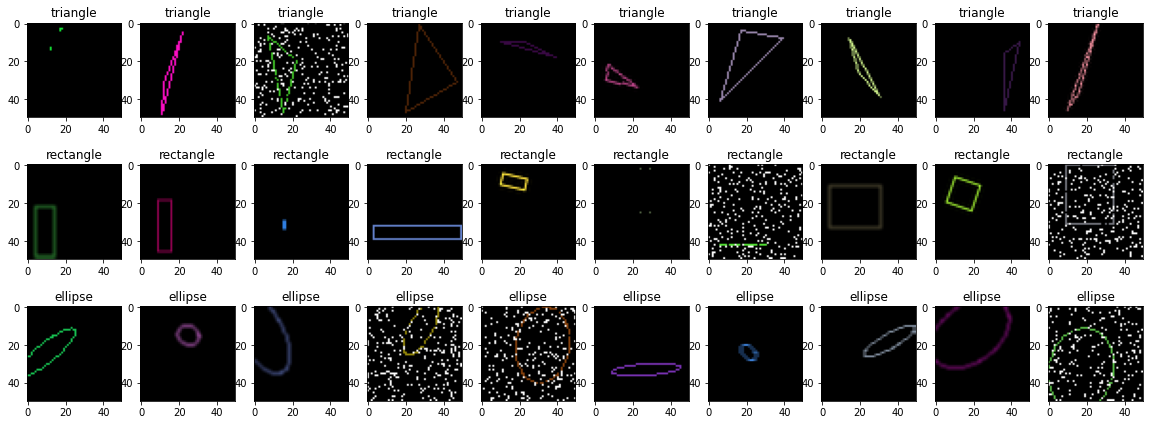

In [27]:
augs_shapes = apply_augmentations(show_shapes)
show_all(augs_shapes, show_lbls, 10)

## **c.** Prepare data in format: (x_train, y_train) , (x_test, y_test) = data.load_data()

In [0]:
def split_train_test(x_set, y_set, ratio=0.9):
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  list_size = len(y_set)
  for i in range(list_size):
    rand_idx = np.random.randint(0, high=len(y_set))
    if len(x_train) < list_size * ratio:
      x_train.append(x_set[rand_idx])
      y_train.append(y_set[rand_idx])
    else:
      x_test.append(x_set[rand_idx])
      y_test.append(y_set[rand_idx])
    x_set.pop(rand_idx)
    y_set.pop(rand_idx)

  return (x_train, y_train) , (x_test, y_test)

In [0]:
def prepare_dataset(shapes : dict, train_test_ratio=0.9):
  shapes = generate_shapes()
  shapes_to_augment = generate_shapes()
  shapes_list, lbls_list = prepare_show_set(shapes, amount_each_shape=len(shapes["triangle"]))
  shapes_aug, lbls_aug = prepare_show_set(shapes, amount_each_shape=len(shapes["triangle"]))
  shapes_aug = apply_augmentations(shapes_aug)
  x_set = shapes_list + shapes_aug
  y_set = lbls_list + lbls_aug
  return split_train_test(x_set, y_set, train_test_ratio)

In [0]:
def pick_shapes_to_show(shapes_list, lbls_list, amount=30):
  shapes = []
  lbls = []
  for i in range(amount):
    shapes.append(shapes_list[i])
    lbls.append(lbls_list[i])
  return shapes, lbls

In [0]:
(x_train_shapes, y_train_shapes), (x_test_shapes, y_test_shapes) = prepare_dataset(shapes)

## Show database:
picking 30 first images from the generated dataset by default, can be changed by adding amount=N as argument in pick_shapes_to_show(...) function.

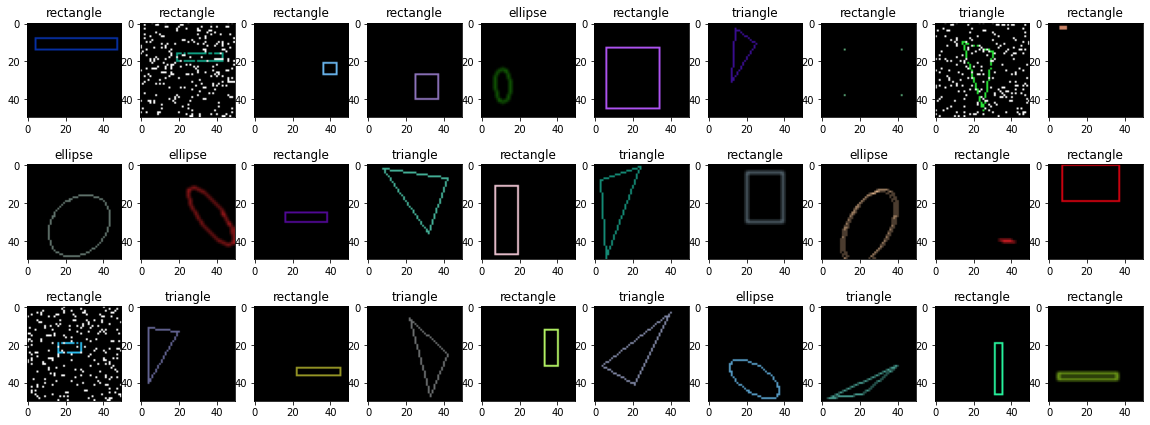

In [32]:
shapes_to_show, lbls_to_show = pick_shapes_to_show(x_train_shapes, y_train_shapes)
show_all(shapes_to_show, lbls_to_show, inarow=10)

## Results and colclusions
In this question we've been asked to generate a dataset of 3 kinds of shapes.
All requested outputs are shown above.
All shapes are generated randomly so there is a lot of diversity berween images.
Also, added another set of shapes with augmentation applied to them so there is a total of 600 shapes by default in this dataset.
Showing above first 30 shapes in the dataset.
With this dataset, a Machine-Learning (ML) Algorithm can learn how to distinguish between ellipse, triangle and rectangle. The dataset can be extended easily by changing a few default parameters controlling amounts.
The augmented images will cause the ML algorithm to "work harder" to classify the shapes which will result improvement in performances.